In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import sklearn
import string
import nltk
import csv
import os
import re

from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords as sw

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

from wordcloud import WordCloud

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

#### Import dataset

In [2]:
DIRPATH = './datasets/T-newsgroups/'

# List of strings (content of each document)
documents_text = []

# List of strings (name (id) of each document)
documents_id = os.listdir(DIRPATH)

# For each file, add its content to documents_text
for file in documents_id:
    with open(DIRPATH + file, 'r', encoding='utf8') as f:
        documents_text.append(f.read())

I have seen, analyzing clusters, that one of these is about sport and, in particular, about baseball. To prevent the tokenizer from splitting the name of a team because of a space between two words, I created a list of baseball teams names (from [this data.world dataset](https://data.world/bgadoci/lahmans-baseball-database)) to use it later.

In [3]:
# Import baseball teams
BASEBALL_FILENAME = './datasets/baseball_teams.csv'
baseball_names = []
with open(BASEBALL_FILENAME) as f:
    header = f.readline()
    name_col_index = header.split(',').index('name')
    for row in csv.reader(f):
        baseball_names.append(row[name_col_index].lower())

# Remove duplicates
baseball_names = list(set(baseball_names))

In [4]:
# Save original documents to be able to restore it when needed without reading all files again
original_documents = documents_text

In [5]:
import multidict as multidict

"""
Extract names from text. Problem: scalability
"""
def extract_entities(text):
    names = []
    for sent in nltk.sent_tokenize(text):
        for chunk in nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(sent))):
            if not isinstance(chunk, tuple):
                if chunk.label() == 'PERSON':
                    names.append(' '.join(c[0] for c in chunk.leaves()))
    return names

"""
Given a list of terms, generate a dictionary with:
    - key: token
    - value: numers of times the token appears in the sentence
Terms not in the list will not be counted.
"""
def getFrequencyDictForText(terms, sentence):
    fullTermsDict = multidict.MultiDict()
    
    # Initialize the dictionary
    tmpDict = {}
    for term in terms:
        tmpDict[term] = 0

    # For each word in sentence
    for text in sentence.split(" "):
        text = text.lower()

        if text not in tmpDict:
            continue

        val = tmpDict.get(text, 0)
        tmpDict[text] = val + 1
    
    for key in tmpDict:
        fullTermsDict.add(key, tmpDict[key])

    return fullTermsDict

"""
Given a document, prepare it before being tokenized
"""
def prepareDocument(document):
    lemmas = []
    
    # Lowerize all the document
    document = document.lower()
    
    # Remove new lines
    document = re.sub(r'\n', ' ', document)

    # Email address
    pattern = re.compile(r'([a-zA-Z0-9._$%+-]+@((?:[a-zA-Z0-9+-]+\.)*([a-zA-Z0-9+-]+\.([a-zA-Z]{2,3}))))')
    for found_match in re.findall(pattern, document):
        full_match = found_match[0]
        domain_level_1 = found_match[3]
        domain_level_2 = found_match[2]

        lemmas.append(full_match)
#       lemmas.append(f'email_1_{domain_level_1}') # Not used: too common
        lemmas.append(f'email_2_{domain_level_2}')
        document = document.replace(full_match, '')
        
    # Telephone number (!!! AFTER EMAIL !!! - otherwise some number in email address could be taken as telephone number)
    pattern = re.compile(r'(\(?([0-9]{3})\)?(?:[ .-]?)([0-9]{3})(?:[ .-]?)([0-9]{4}))')
    for found_match in re.findall(pattern, document):
        full_match = found_match[0]
        tel_number = ''.join(found_match[1:])
        lemmas.append(tel_number)
        document = document.replace(full_match, '')

    # University name
    pattern = re.compile(r'(university of [a-z]+)')
    for full_match in re.findall(pattern, document):
        lemmas.append('university') # we're talking about univeristy
        lemmas.append(full_match)   # we're talking about that specific university
        document = document.replace(full_match, '')

    # Date
    pattern = re.compile(r'date.{1,5}((?:sun|mon|tue|wed|thu|fri|sat)[^\d]{1,3}(\d\d?)[^\d]{1,3}(jan|feb|mar|apr|may|aug|sep|oct|nov|dec)[^\d]{1,3}(\d\d(?:\d\d)?))')
    for found_match in re.findall(pattern, document):
        full_match = found_match[0]
        year = found_match[3]
        month = found_match[2]
        day = found_match[1]
        lemmas.append(f'{year}-{month}-{day}')
        lemmas.append(f'{year}-{month}')
        lemmas.append(f'{year}')
        document = document.replace(full_match, '')

    # Organization
    pattern = re.compile(r'organization\W{1,5}([a-z0-9 ]*)\n')
    for full_match in re.findall(pattern, document):
        lemmas.append(f'{full_match}')
        document = document.replace(full_match, '')

    # Distribution
    pattern = re.compile(r'distribution\W{1,5}([a-z0-9 ]*)\n')
    for full_match in re.findall(pattern, document):
        lemmas.append(f'distribution_{full_match}')
        document = document.replace(full_match, '')
    
    # Remove the signature (it is common to find quotes - removed because a quote may talk about a different context)
    splitted_document = re.compile('[-=]{2,}').split(document)
    if len(splitted_document) > 1:
        document = ''.join(splitted_document[:-1])
    
    # Baseball team
    for team_id, baseball_name in enumerate(baseball_names):
        document = document.replace(baseball_name, f'baseball_team_{team_id}')
    
    # Remove non char longer than 1 (e.g. "*****", "------", "#######", "~~~~~~~", ...)
    document = re.sub(r'[^a-zA-Z0-9 ]{2,}', '', document)
        
    
    return document, lemmas

def originalIdToListId(original_id, documents_id):
    for i, document_id in enumerate(documents_id):
        if document_id == original_id:
            return i
    return -1

class LemmaTokenizer(object):
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        
    def __call__(self, document):
        document, lemmas = prepareDocument(document)
        
        for t in word_tokenize(document):
            t = t.strip()
            lemma = self.lemmatizer.lemmatize(t)
            if len(lemma) > 1:
                lemmas.append(lemma)
        return lemmas

#### Pre-processing

In [6]:
documents_text = original_documents
# documents_text = prepareDocuments(documents_text)
lemmaTokenizer = LemmaTokenizer()
stop_words = sw.words('english')
stop_words += ["'d", "'", "''", '``',
               "'ll", "'re", "'s", "'m", "'ve", 'could', 'doe', 'ha', 'might', 'must', "n't",
               'need', 'sha', 'wa', 'wo', 'would', 'use', 'many', 'may', 'see',]
stop_words += ['one', 'like', 'get', 'know', 'think', 'people',
               'anyone','thanks','nntp-posting-host','also',
                'please','message-id','say','new','make','thing',
                'day','reference', 'writes', 'article']
# ['writes', 'like', "'", 'used', 'think', 'people',"'d", "'ll", "'re", "'s", "'ve", 'might', 'must',
# "n't", 'need', 'sha', 'wo','many', 'much', 'use', 'know', 'get', 'would', 'im', 'one', 'u', 'arent',
# 'could', 'couldnt', 'didnt', 'doesnt', 'dont', 'ha', 'hadnt', 'hasnt', 'havent', 'isnt', 'mightnt', 'mustnt',
# 'neednt', 'shant', 'shes', 'shouldnt', 'shouldve', 'thatll', 'wasnt', 'werent', 'wont', 'wouldnt', 'youd', 'youll',
# 'youre', 'youve', 'doe', 'wa']
vectorizer = TfidfVectorizer(tokenizer=lemmaTokenizer,stop_words=stop_words, min_df=2, max_df=.35, max_features=10000)

tfidf_X = vectorizer.fit_transform(documents_text)

#### Graphically represent the entire dataset

##### a) with TFIDF

In [7]:
tdm = tfidf_X
    
freqs_sum = {}
freqs_avg = {}
freqs_max = {}
for word, idx in vectorizer.vocabulary_.items():
    val = tdm.getcol(idx)
    freqs_sum[word] = val.sum()
    freqs_avg[word] = val.mean()
    freqs_max[word] = val.max()

SUM


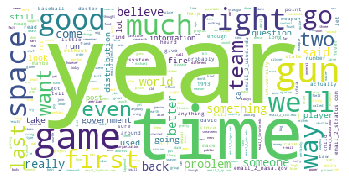

AVG


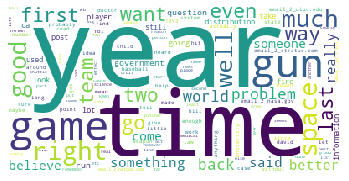

MAX


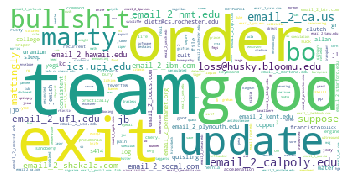

In [8]:
print("SUM")
w1 = WordCloud(background_color='white',max_words=1000).fit_words(freqs_sum)
plt.imshow(w1)
plt.axis('off')
plt.show()

print("AVG")
w2 = WordCloud(background_color='white',max_words=1000).fit_words(freqs_avg)
plt.imshow(w2)
plt.axis('off')
plt.show()

print("MAX")
w3 = WordCloud(background_color='white',max_words=1000).fit_words(freqs_max)
plt.imshow(w3)
plt.axis('off')
plt.show()

In [9]:
print("SUM")
sorted_freqs = [{'token': k, 'freq': v} for k, v in freqs_sum.items()]
display(sorted(sorted_freqs, key = lambda i: (i['freq']), reverse=True)[:10])

print("AVG")
sorted_freqs = [{'token': k, 'freq': v} for k, v in freqs_avg.items()]
display(sorted(sorted_freqs, key = lambda i: (i['freq']), reverse=True)[:10])

print("MAX")
sorted_freqs = [{'token': k, 'freq': v} for k, v in freqs_max.items()]
display(sorted(sorted_freqs, key = lambda i: (i['freq']), reverse=True)[:20])

SUM


[{'token': 'year', 'freq': 60.12335584709596},
 {'token': 'time', 'freq': 54.244574975276436},
 {'token': 'game', 'freq': 53.765220202570674},
 {'token': 'gun', 'freq': 51.45885976038754},
 {'token': 'right', 'freq': 47.44731804067028},
 {'token': 'space', 'freq': 46.988545635968975},
 {'token': 'good', 'freq': 44.26665124902965},
 {'token': 'much', 'freq': 40.76257266753804},
 {'token': 'well', 'freq': 40.37550778024908},
 {'token': 'first', 'freq': 39.13487405810909}]

AVG


[{'token': 'year', 'freq': 0.015030838961773988},
 {'token': 'time', 'freq': 0.013561143743819112},
 {'token': 'game', 'freq': 0.013441305050642668},
 {'token': 'gun', 'freq': 0.012864714940096885},
 {'token': 'right', 'freq': 0.011861829510167572},
 {'token': 'space', 'freq': 0.011747136408992241},
 {'token': 'good', 'freq': 0.011066662812257412},
 {'token': 'much', 'freq': 0.010190643166884509},
 {'token': 'well', 'freq': 0.010093876945062271},
 {'token': 'first', 'freq': 0.009783718514527272}]

MAX


[{'token': 'team', 'freq': 1.0},
 {'token': 'good', 'freq': 1.0},
 {'token': 'order', 'freq': 1.0},
 {'token': 'exit', 'freq': 1.0},
 {'token': 'update', 'freq': 1.0},
 {'token': 'bullshit', 'freq': 1.0},
 {'token': 'bo', 'freq': 1.0},
 {'token': 'marty', 'freq': 1.0},
 {'token': 'email_2_calpoly.edu', 'freq': 1.0},
 {'token': 'email_2_ca.us', 'freq': 1.0},
 {'token': 'loss@husky.bloomu.edu', 'freq': 1.0},
 {'token': 'mattingly', 'freq': 0.9903933656871996},
 {'token': 'ics.uci.edu', 'freq': 0.9596071763790691},
 {'token': 'jb', 'freq': 0.9246205110722637},
 {'token': 'email_2_nmt.edu', 'freq': 0.8980872392846856},
 {'token': 'suppose', 'freq': 0.8735905511710348},
 {'token': 'email_2_ufl.edu', 'freq': 0.869480125427855},
 {'token': 'email_2_shakala.com', 'freq': 0.8687477135769719},
 {'token': 'email_2_hawaii.edu', 'freq': 0.8586016523782816},
 {'token': 'email_2_socal.com', 'freq': 0.8499453013940883}]

##### b) with word frequencies

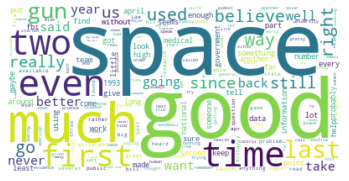

In [10]:
text = ''
for document_text in documents_text:
    text += document_text
terms = vectorizer.get_feature_names()
text_freq = getFrequencyDictForText(terms, text)
wc = WordCloud(background_color='white', max_words=1000)
wc.generate_from_frequencies(text_freq)

plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

#### Number of clusters found: 4

Four clusters found by looking at the result after having tried different numbers.

CLUSTERS:
- space
- gun / fire
- game
- medicine

In [18]:
n_clusters = 4

model = KMeans(n_clusters=n_clusters, n_jobs=-1)
labels = model.fit_predict(tfidf_X)

unique_labels = list(set(labels))

n_items = []

for label in unique_labels:
    n = len(list(filter(lambda x: x == label, labels)))
    n_items.append(n)
    print(f"Label {label}: {n} items")

Label 0: 642 items
Label 1: 701 items
Label 2: 775 items
Label 3: 1882 items


#### WordCloud

Top terms per cluster:
Cluster 0 (642 elements)


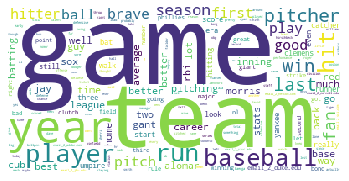

Cluster 1 (701 elements)


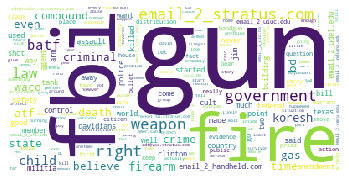

Cluster 2 (775 elements)


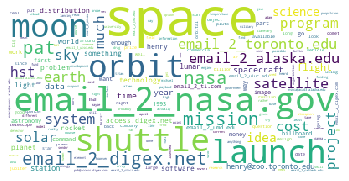

Cluster 3 (1882 elements)


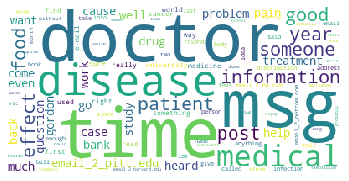

In [19]:
max_terms = 100

print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
dist_from_centroid = model.cluster_centers_
terms = vectorizer.get_feature_names()

for label in range(len(unique_labels)):
    number_of_element_in_label = len([1 for x in labels if x == label])
    print(f"Cluster {label} ({number_of_element_in_label} elements)"),
    freqs = {terms[x]: dist_from_centroid[label][x] for x in order_centroids[label]}
    w = WordCloud(background_color='white').fit_words(freqs)
    plt.imshow(w)
    plt.axis('off')
    plt.show()

In [20]:
for label in range(len(unique_labels)):
    number_of_element_in_label = len([1 for x in labels if x == label])
    print(f"Cluster {label} ({number_of_element_in_label} elements)"),
    terms_dict = [{'term': terms[x], 'dist': dist_from_centroid[label][x]} for x in order_centroids[label]]
    terms_dict = sorted(terms_dict, key=lambda x: (x['dist']), reverse=True)
    
    common_words_list = '['
    for term in terms_dict[:20]:
        term_word = term['term']
        term_dist = term['dist']
        print(f"  - {term_word}\t\t({term_dist})")
        common_words_list += f"'{term_word}',"
    common_words_list += ']'
    print(common_words_list)

Cluster 0 (642 elements)
  - game		(0.0777214813599638)
  - team		(0.04840055780443191)
  - year		(0.042451779478221374)
  - player		(0.03679528534033026)
  - run		(0.03348632597401213)
  - hit		(0.03163269969431822)
  - baseball		(0.03134701399813426)
  - pitcher		(0.027235442027705073)
  - last		(0.027227233544022823)
  - win		(0.025682830582981327)
  - fan		(0.024028879122395305)
  - season		(0.023134848419885026)
  - pitch		(0.020992032017296443)
  - ball		(0.020819211955253502)
  - good		(0.020758733306765042)
  - brave		(0.020182484695774442)
  - first		(0.019127388961596332)
  - hitter		(0.01893252106991569)
  - play		(0.01848984594664662)
  - pitching		(0.01799617738321915)
['game','team','year','player','run','hit','baseball','pitcher','last','win','fan','season','pitch','ball','good','brave','first','hitter','play','pitching',]
Cluster 1 (701 elements)
  - gun		(0.06900777531982523)
  - fbi		(0.03686478855312503)
  - fire		(0.036708460565456576)
  - email_2_stratus.com		(0.03

Label no 0
1650 elements in this label


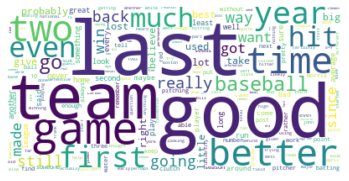

Label no 1
701 elements in this label


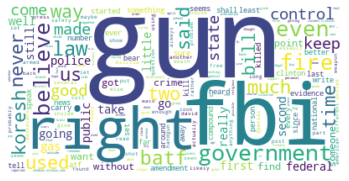

Label no 2
1012 elements in this label


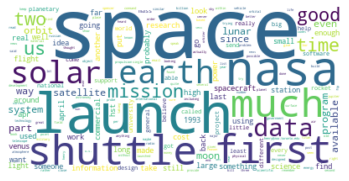

Label no 3
637 elements in this label


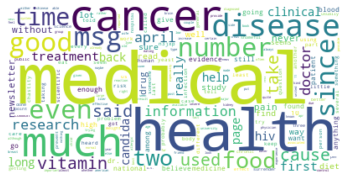

In [33]:
for i, unique_label in enumerate(unique_labels):
    print(f"Label no {i}")
    
    number_of_element_in_label = len([1 for x in labels if x == i])
    print(f"{number_of_element_in_label} elements in this label")
    if number_of_element_in_label == 0:
        continue
    
    text = ''
    for j, label in enumerate(labels):
        if label == i:
            text += documents_text[j]

    text_freq = getFrequencyDictForText(terms, text)

    wc = WordCloud(background_color='white')
    wc.generate_from_frequencies(text_freq)

    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

#### Consideration

All clusters are well-defined except one, which contains all ambiguous documents. This may be because it exists another cluster that I am ignoring. However, when I try to increase the number of clusters I get weird result.

For instance, by considering 5 clusters, the clusters won't change except for "gun/fire", which will be splitted in "gun" and "fire".

When considering 6 clusters, the same thing happens but the "junk" cluster is splitted from the others (or "medicine" and "food" are splitted). I cannot find a topic for this cluster. I can find a lot of documents from other clusters, so I suppose that the document representation has a problem in representing these documents on the space, by putting them away from the others of the same cluster.

Gun cluster id: 1 (487 documents)


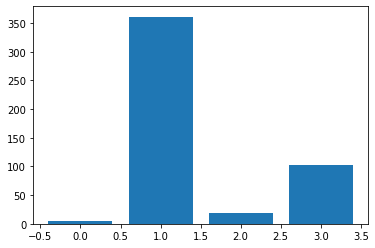

Fire cluster id: 1 (428 documents)


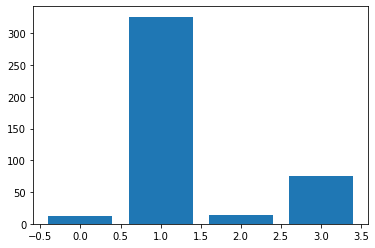

Space cluster id: 2 (499 documents)


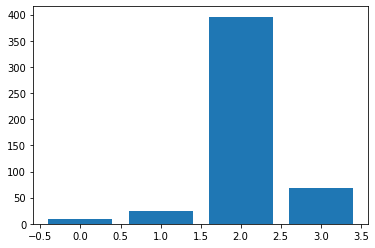

Game cluster id: 0 (444 documents)


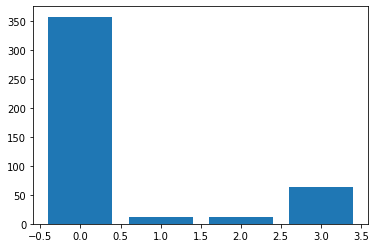

Medicine cluster id: 3 (112 documents)


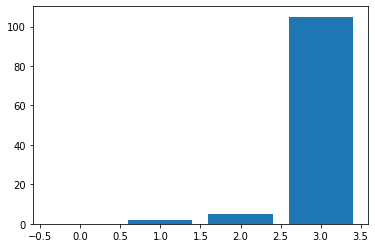

Generic cluster id: 3 (436 documents)


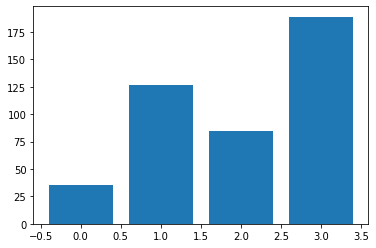

In [22]:
def numberOfDocumentsWithAWord(word, documents):
    cnt = 0
    for document in documents:
        if word in document:
            cnt += 1
    return cnt

def statsForWord(word):
    clusters_num = len(unique_labels)
    
    num_by_id = [0] * len(unique_labels)
    
    for i in range(clusters_num):
        documents_text_label = []
        for j, document_text in enumerate(documents_text):
            if labels[j] == i:
                documents_text_label.append(document_text)
        number_of_documents = numberOfDocumentsWithAWord(word, documents_text_label)
        num_by_id[i] += number_of_documents

    return np.argmax(num_by_id), num_by_id, numberOfDocumentsWithAWord(word, documents_text)

clusters_num = len(unique_labels)

gun_cluster_id, num_gun_by_id, num_gun = statsForWord('gun')
fire_cluster_id, num_fire_by_id, num_fire = statsForWord('fire')
space_cluster_id, num_space_by_id, num_space = statsForWord('space')
game_cluster_id, num_game_by_id, num_game = statsForWord('game')
medicine_cluster_id, num_medicine_by_id, num_medicine = statsForWord('medicine')
generic_cluster_id, num_generic_by_id, num_generic = statsForWord('someone')

print(f"Gun cluster id: {gun_cluster_id} ({num_gun} documents)")
plt.bar(x=range(clusters_num), height=num_gun_by_id)
plt.show()
print(f"Fire cluster id: {fire_cluster_id} ({num_fire} documents)")
plt.bar(x=range(clusters_num), height=num_fire_by_id)
plt.show()
print(f"Space cluster id: {space_cluster_id} ({num_space} documents)")
plt.bar(x=range(clusters_num), height=num_space_by_id)
plt.show()
print(f"Game cluster id: {game_cluster_id} ({num_game} documents)")
plt.bar(x=range(clusters_num), height=num_game_by_id)
plt.show()
print(f"Medicine cluster id: {medicine_cluster_id} ({num_medicine} documents)")
plt.bar(x=range(clusters_num), height=num_medicine_by_id)
plt.show()
print(f"Generic cluster id: {generic_cluster_id} ({num_generic} documents)")
plt.bar(x=range(clusters_num), height=num_generic_by_id)
plt.show()

Note: the number of document is only based on the frequency of the most important word for that topic.

#### Post-processing

In [23]:
""" Merge 'gun' and 'fire' clusters """
for i, label in enumerate(labels):
    if label == fire_cluster_id:
        labels[i] = gun_cluster_id

#### Reiterate on general cluster

In [24]:
""" Generate two new lists for contents and indices of documents """
general_documents = []
general_documents_id = []
for i, label in enumerate(labels):
    if label == generic_cluster_id:
        general_documents.append(documents_text[i])
        general_documents_id.append(documents_id[i])

In [25]:
general_lemmaTokenizer = LemmaTokenizer()
general_vectorizer = TfidfVectorizer(tokenizer=lemmaTokenizer,stop_words=stop_words, min_df=2, max_df=0.7)

general_tfidf_X = general_vectorizer.fit_transform(general_documents)

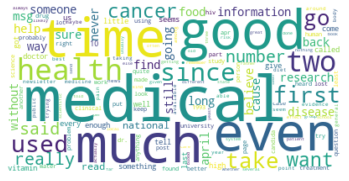

In [26]:
text = ''
for document_text in general_documents:
    text += document_text
terms = vectorizer.get_feature_names()
text_freq = getFrequencyDictForText(terms, text)
wc = WordCloud(background_color='white', max_words=1000)
wc.generate_from_frequencies(text_freq)

plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [27]:
general_model = KMeans(n_clusters=4, n_jobs=-1)
general_labels = general_model.fit_predict(general_tfidf_X)

general_unique_labels = list(set(general_labels))

general_n_items = []

for label in general_unique_labels:
    general_n = len(list(filter(lambda x: x == label, general_labels)))
    general_n_items.append(general_n)
    print(f"Label {label}: {general_n} items")

Label 0: 61 items
Label 1: 1008 items
Label 2: 237 items
Label 3: 576 items


Top terms per cluster:
Cluster 0 (61 elements)


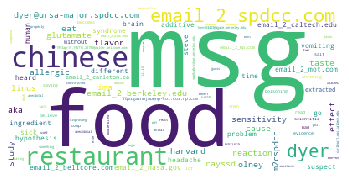

Cluster 1 (1008 elements)


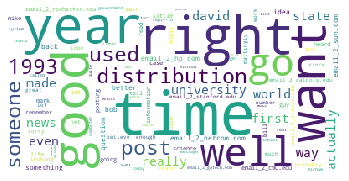

Cluster 2 (237 elements)


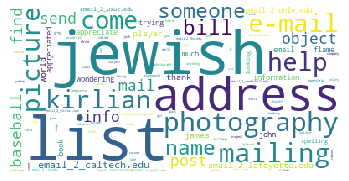

Cluster 3 (576 elements)


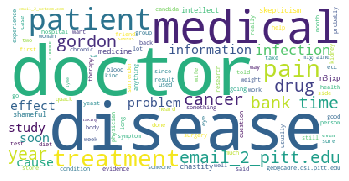

In [28]:
max_terms = 100

print("Top terms per cluster:")
general_order_centroids = general_model.cluster_centers_.argsort()[:, ::-1]
general_dist_from_centroid = general_model.cluster_centers_
general_terms = general_vectorizer.get_feature_names()

for label in range(len(general_unique_labels)):
    number_of_element_in_label = len([1 for x in general_labels if x == label])
    print(f"Cluster {label} ({number_of_element_in_label} elements)"),
    freqs = {general_terms[x]: general_dist_from_centroid[label][x] for x in general_order_centroids[label]}
    w = WordCloud(background_color='white',max_words=100).fit_words(freqs)
    plt.imshow(w)
    plt.axis('off')
    plt.show()

Label no 0
61 elements in this label


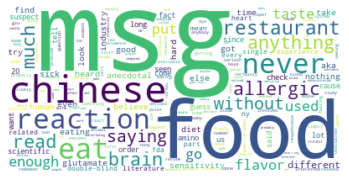

Label no 1
1008 elements in this label


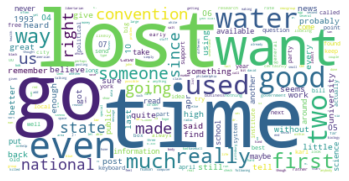

Label no 2
237 elements in this label


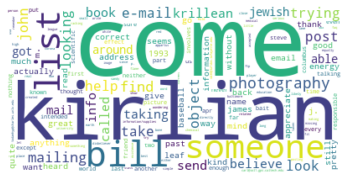

Label no 3
576 elements in this label


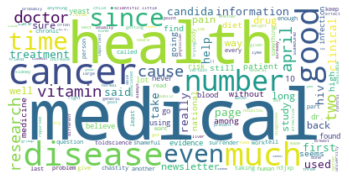

In [29]:
for i, unique_label in enumerate(general_unique_labels):
    print(f"Label no {i}")
    
    number_of_element_in_label = len([1 for x in general_labels if x == i])
    print(f"{number_of_element_in_label} elements in this label")
    if number_of_element_in_label == 0:
        continue
    
    text = ''
    for j, label in enumerate(general_labels):
        if label == i:
            text += general_documents[j]

    text_freq = getFrequencyDictForText(terms, text)

    wc = WordCloud(background_color='white', max_words=1000)
    wc.generate_from_frequencies(text_freq)

    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [31]:
""" Manually assign these new clusters to the right cluster (by looking at the wordcloud) """
assign_cluster = {
    0: medicine_cluster_id,
    1: game_cluster_id, # junk cluster
    2: space_cluster_id,
    3: medicine_cluster_id,
}

for i, general_document_id in enumerate(general_documents_id):
    original_list_id = originalIdToListId(general_document_id, documents_id)
    labels[original_list_id] = assign_cluster[general_labels[i]]

#### Save solution

In [34]:
with open("solution.csv", "w+") as f:
    f.seek(0)
    f.write("Id,Predicted\n")
    for i, label in enumerate(labels):
        curr_id = documents_id[i]
        f.write(f"{curr_id},{label}\n")

#### Write generic files on folder

Used to analyze documents that I was unable to clusterize

In [ ]:
GENERIC_FILES_PATH = './generic_files/'

for i, label in enumerate(labels):
    if label == generic_cluster_id:
        with open(GENERIC_FILES_PATH + documents_id[i], mode='w+') as f:
            f.write(original_documents[i])